In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def classifier_pipeline(data: pd.DataFrame, target_var: str, classifier, cv_grid: dict):
    """
    creates a random foreset pipeline for classification

    Params: 
    data: pandas data frame used for classification
    target_var: variables name for target var
    classifier: provided classifier for pipeline
    cv_grid: parameter grid for cross validation

    Returns: 
    best_mod: best model chosen from cross validation
    X_test: feature data used for testing
    y_test: target data used for testing
    """
    
    from sklearn.model_selection import train_test_split, RandomizedSearchCV
    from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
    from sklearn.pipeline import Pipeline
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer, SimpleImputer
    from sklearn.compose import ColumnTransformer
    
    data = data.copy()
    data.dropna(subset=(target_var), inplace=True)
    X = data.drop(target_var, axis="columns")
    y = data[target_var]
    y.hist()
    plt.savefig("class_distributions")
    
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    y_resampled.hist()
    plt.savefig("resampled_distributions")
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                         train_size=.8, 
                                                         random_state=117)
    
    num_cols = list(data.select_dtypes(include="float64").columns)
    cat_cols = list(data.select_dtypes(include="object").columns)
    cat_cols.remove(target_var)
    
    num_pipe = Pipeline([("it_impu", IterativeImputer()), 
                                    ("min_max", MinMaxScaler())])
    cat_pipe = Pipeline([("cat_impu", SimpleImputer(strategy="most_frequent")),
                         ('encoder', OneHotEncoder(handle_unknown="ignore"))])
    
    col_t = ColumnTransformer([("num_transform", num_pipe, num_cols), 
                              ('cat_transform', cat_pipe, cat_cols)])
    
    class_pipe = Pipeline([("col_transform", col_t),
                        ("class", classifier)])
    
    grid_clf = RandomizedSearchCV(estimator=class_pipe, 
                                  param_distributions=cv_grid,
                                  scoring="accuracy", cv=10, 
                                  verbose=False)
    grid_clf.fit(X_train, y_train)
    best_mod = grid_clf.best_estimator_
    best_mod.fit(X_train, y_train)

    return best_mod, X_test, y_test

Number of Common Heros: 770
<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 0 to 769
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hero             770 non-null    object 
 1   Gender_x         744 non-null    object 
 2   Eye color        593 non-null    object 
 3   Race_x           429 non-null    object 
 4   Hair color       592 non-null    object 
 5   Height_x         770 non-null    float64
 6   Publisher_x      763 non-null    object 
 7   Skin color       65 non-null     object 
 8   Alignment_x      767 non-null    object 
 9   Weight_x         770 non-null    float64
 10  Identity         277 non-null    object 
 11  Status           359 non-null    object 
 12  Gender_y         757 non-null    object 
 13  Alignment_y      769 non-null    object 
 14  Race_y           429 non-null    object 
 15  Height_y         552 non-null    float64
 16  Weight_y         544 non-null    f

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

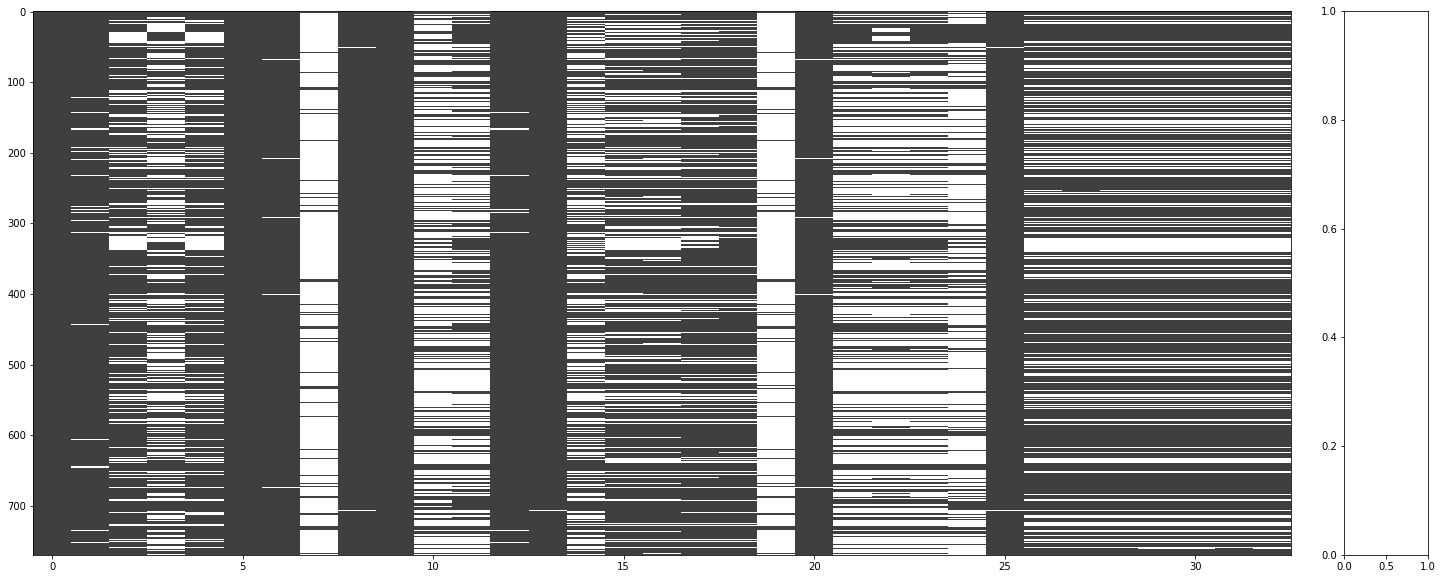

In [9]:
import pandas as pd
import os
import missingno as msno
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np


def read_data(file_list: list) -> list:
    """
    read data reads in list of provided data

    Params:
    file_list: list of files contained within 
    a directory 
    
    Returns:
    list of data frames for merging 
    
    """
    return [
        pd.read_csv("data/" + file).replace("-", np.nan)
        for file in file_list
        if file != "merged_dat.csv"
    ] 


def prelim_analysis(df_list: list, possible_hero_col: list, fig_title: str) -> None:
    """
    prelim analysis looks to do a quick analysis
    of the commonality and completeness across the
    data sets

    Params:
    df_list: list data frames read in 
    possible_hero_cols: list of column names
    that are hero columns across data sets
    fig_title: title for matrix plot

    Returns: 
    merged data
    """

    df_list = df_list.copy()
    df_list = [df.drop(["Unnamed: 0"], axis=1) if "Unnamed: 0" in list(df.columns) else df for df in df_list ]
    colnames = [list(df.columns) for df in df_list]
    flatten_cols = [subcols  for cols in colnames for subcols in cols]
    
    hero_col_names = [col for col in flatten_cols if col.lower() in possible_hero_col]
    renamed_heros_col = possible_hero_col[0]
    heros = [pd.DataFrame(df).rename(columns={hero_col:renamed_heros_col}) 
            for df, hero_col in zip(df_list, hero_col_names)]
    
    common_heros = reduce(lambda df1,df2: pd.merge(df1,df2,on=possible_hero_col[0]), heros)
    print("Number of Common Heros:", len(common_heros[renamed_heros_col]))
    print(common_heros.info())

    msno.matrix(msno.nullity_sort(common_heros))
    plt.savefig(fig_title)

    return common_heros


def clean_data(merged_data_set: pd.DataFrame, cols_to_drop: list, prelim: pd.DataFrame):
    """
    clean data takes in raw uncleaned data,
    and drops and cleans for feature engineering

    Params:
    merged_data_set: data frame of raw uncleaned data
    cols_to_drop: columns that are redundant and or
    to sparse for usage and will be dropped
    prelim: analysis function to give basic missingness stats

    Returns: 
    None 
    """

    merged_data_set = merged_data_set.copy()
    merged_data_set.drop(cols_to_drop, 
                         axis="columns", 
                         inplace=True)
    merged_data_set.columns = map(str.lower, 
                                  merged_data_set.columns)
    merged_data_set.columns = merged_data_set.columns.str.rstrip('_x')
    merged_data_set.drop_duplicates(inplace=True)
    
    num_cols = list(merged_data_set.select_dtypes(include="float64").columns)
    merged_data_set[num_cols] = merged_data_set[num_cols].apply(np.abs)
    print(merged_data_set[num_cols].describe())
    
    cat_cols = list(merged_data_set.select_dtypes(include="object").columns)
    print(merged_data_set[cat_cols].describe())

    prelim([merged_data_set],
           ["hero"],
           "missing_mat_non_red")
    
    merged_data_set.to_csv("data/merged_dat.csv")
    

unmerged_dfs = read_data(file_list=os.listdir("data/"))
merged_data = prelim_analysis(df_list=unmerged_dfs, 
                              possible_hero_col=["hero", "name"], 
                              fig_title="raw_missing_mat")
drop_cols = [
    "Identity", 
    "Status", 
    "Race_y", 
    "Gender_y", 
    "Alignment_y", 
    "Height_y", 
    "Weight_y", 
    "EyeColor", 
    "SkinColor", 
    "Publisher_y",
    "Year", 
    "Appearances", 
    "FirstAppearance", 
    "AdditionalData", 
    "Total", 
    "Alignment", 
    "Hair color",
    "Skin color"
]
clean_data(merged_data_set=merged_data, 
           cols_to_drop=drop_cols, 
           prelim=prelim_analysis) 

              precision    recall  f1-score   support

         bad       0.74      0.89      0.81        82
        good       0.87      0.78      0.82       112
     neutral       1.00      0.95      0.97        94

    accuracy                           0.86       288
   macro avg       0.87      0.87      0.87       288
weighted avg       0.87      0.86      0.87       288



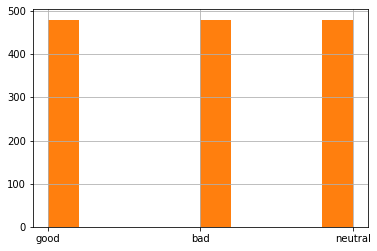

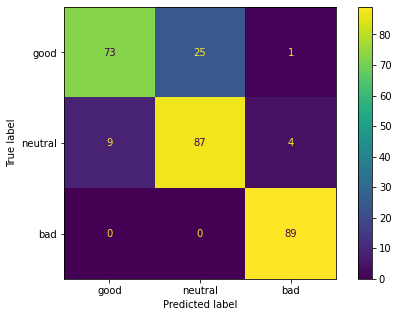

              precision    recall  f1-score   support

         bad       0.90      0.82      0.86       109
        good       0.80      0.89      0.84        90
     neutral       1.00      1.00      1.00        89

    accuracy                           0.90       288
   macro avg       0.90      0.90      0.90       288
weighted avg       0.90      0.90      0.90       288



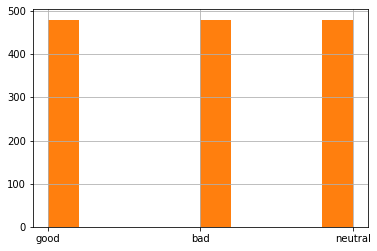

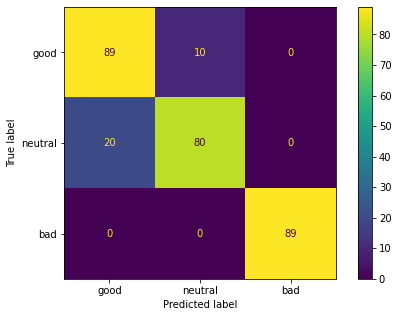

              precision    recall  f1-score   support

         bad       0.88      0.96      0.92        91
        good       0.96      0.89      0.92       108
     neutral       1.00      1.00      1.00        89

    accuracy                           0.94       288
   macro avg       0.95      0.95      0.95       288
weighted avg       0.95      0.94      0.94       288



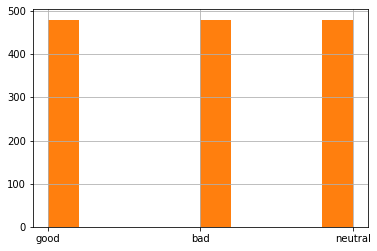

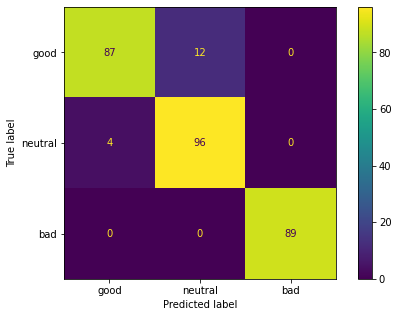

In [7]:
from classifier_pipe import classifier_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def metrics(mod, X_t: pd.DataFrame, y_t: pd.DataFrame)->None:
    """
    produces metrics for given model

    Params:
    model: fitted model
    X_t: x testing data
    y_tL y training data

    Returns:
    None

    """
    from sklearn.metrics import classification_report
    from sklearn.metrics import brier_score_loss
    from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

    preds = mod.predict(X_t)
    probs = mod.predict_proba(X_t)
    print(classification_report(preds, y_t)) 

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_t, preds),
        display_labels=["good", "neutral", "bad"]
    )
    
    cmp.plot(ax=ax)
    plt.show()


unengineered_dat = pd.read_csv("data/merged_dat.csv")
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
param_grid = {
                 'class__n_estimators': np.arange(10, 110, 10),
                 'class__max_depth': np.arange(1, 10, 1)
             }
rf_model, X_test, y_test = classifier_pipeline(unengineered_dat, "alignment", classifier=rf_classifier, cv_grid=param_grid)
metrics(mod=rf_model, X_t=X_test, y_t=y_test) 

from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression()
lr_param_grid = {
                    "class__penalty": ["l2", "none"],
                    "class__max_iter": np.arange(100, 10000, 100),
                    "class__multi_class": ["ovr","auto"]
                }
lr_model, X_test, y_test = classifier_pipeline(unengineered_dat, "alignment", classifier=lr_classifier, cv_grid=lr_param_grid)
metrics(mod=lr_model, X_t=X_test, y_t=y_test)

from sklearn.ensemble import ExtraTreesClassifier
et_classifier = ExtraTreesClassifier()
et_param_grid = {
                    "class__n_estimators": np.arange(50,500,25), 
                }
et_model, X_test, y_test = classifier_pipeline(unengineered_dat, "alignment", classifier=et_classifier, cv_grid=et_param_grid)
metrics(mod = et_model, X_t=X_test, y_t=y_test)